In [1]:
%cd ..

/sunjinsheng/sunpiece/mar


In [2]:
from pathlib import Path

from PIL import Image
import torch 
import torchvision.transforms as tf
from einops import rearrange,repeat

In [4]:
from models.mae import mae_vit_base_patch56
model = mae_vit_base_patch56()

In [7]:
path_image = 'data/RealHM/vendor_testing_2/pexels-craig-adderley-1563356_fore.jpg'

In [5]:
transfroms = tf.Compose([
    tf.Resize((224,224)),
    tf.ToTensor()
])
transfroms_gray = tf.Compose([
    tf.Grayscale(),
    tf.Resize((224, 224)),
    tf.ToTensor()
])

In [38]:
import numpy as np

In [ ]:
# image = 255*np.ones((224,224,3))
# image[:,:,1:] = 0
# image = Image.fromarray(image.astype(np.uint8))

In [69]:
image = Image.open(path_image).convert('RGB')
tensor_image = transfroms(image)
tensor_image = tensor_image.unsqueeze(0)
tensor_gray = transfroms_gray(image)
tensor_gray = tensor_gray.unsqueeze(0)
tensor_gray = tensor_gray.expand(-1, 3, -1, -1)
tensor_image.shape, tensor_gray.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [174]:
def tensor_2_image(x:torch.Tensor) -> Image:
    # x.shape: n c h w
    assert 4 == x.dim() 
    x = rearrange(x, 'n c h w -> c h (w n)')
    # (255*x.clip(0,1)).to(torch.uint8).cpu().numpy()
    return tf.functional.to_pil_image(x)
def tensor_2_patch_image(x:torch.Tensor, patch_size:int=16) -> Image:
    b,c,h,w= x.shape
    p = q = patch_size
    h_ = h // p
    w_ = w // q
    x = rearrange(x, 'n c (h p) (w q) -> n c (h w) p q', p = p, q = q)
    # x = rearrange(x, 'b c (h p) (w q) -> b (h w) (c p q)', p=p, q=q)
    # x = rearrange(x, 'b (h w) (c p q) -> b c (h p) (w q)', c=c, h=h_, w=w_, p=p,q=q)
    x = torch.nn.functional.pad(x, (2,2,2,2), mode='constant', value=0.6)
    _,_,_, p, q = x.shape
    x = rearrange(x, 'n c L p q -> n c (p q)  L')
    # noise = torch.rand(x.shape[-1])
    # ids_random = torch.argsort(noise)
    # ids_random = ids_random.expand(1,3,p*q,-1)
    # x = torch.gather(x, dim = 3, index=ids_random)
    x = rearrange(x, ' n c (p q) (h w) -> c (n h p) (w q)', p = p, h = h_, )
    x = x[:,2:-2,2:-2]
    return tf.functional.to_pil_image(x)

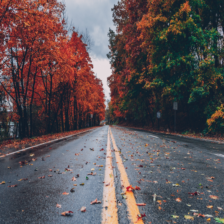

In [70]:
tensor_2_image(tensor_image)

In [118]:
tensor_pure = 0.3*torch.ones_like(tensor_gray)

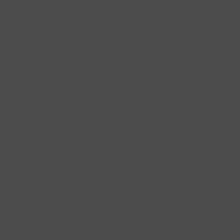

In [119]:
tensor_2_image(tensor_pure)

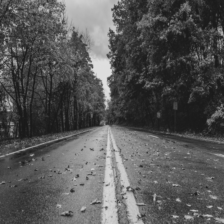

In [71]:
tensor_2_image(tensor_gray)

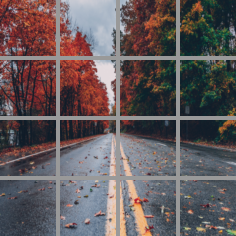

In [158]:
tensor_2_patch_image(tensor_image, patch_size=56)

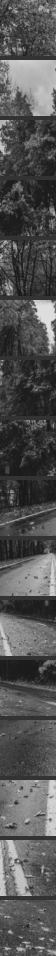

In [105]:
tensor_2_patch_image(tensor_gray, patch_size=56)

In [120]:
x = tensor_image.detach().clone()
g = tensor_gray.detach().clone()
p = tensor_pure

In [75]:
model.patch_embed.patch_size

(56, 56)

In [121]:
x_patched = model.patchify(x)
g_patched = model.patchify(g)
p_patched = model.patchify(p)
mask_ratio = 0.4

In [49]:
x_patched.shape  #x: (N, L=h_*w_, patch_size**2*channel)
# patch_size : p = q = 16 
# h_ = h // p : 224 // 16 = 14
# w_ = w // q : 224 // 16 = 14 
# channel_size : c = 3
# >>
# N = 1
# L = h_ * w_ = 14 * 14 = 196  
# D = p * q * c = 16 * 16 * 3 = 768

torch.Size([1, 16, 9408])

In [77]:
x_hat = model.unpatchify(x_patched)

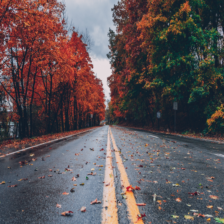

In [78]:
tensor_2_image(x_hat)

## random graying

In [79]:
# def random_masking(x, mask_ratio):
"""
Perform per-sample random masking by per-sample shuffling.
Per-sample shuffling is done by argsort random noise.
x: [N, L, D], sequence
"""
N, L, D = x_patched.shape  # batch, length, dim
len_keep = int(L * (1 - mask_ratio))

In [147]:
torch.manual_seed(20)
noise = torch.rand(N, L, device=x_patched.device)  # noise in [0, 1]
noise.shape
# sort noise for each sample
ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
ids_restore = torch.argsort(ids_shuffle, dim=1)
ids_restore

tensor([[ 9,  2, 12,  7,  4, 11, 13,  1,  3, 14,  0,  6, 15,  5, 10,  8]])

In [ ]:
# keep the first subset
ids_keep = ids_shuffle[:, :len_keep]
ids_gray = ids_shuffle[:, len_keep:]
x_masked = torch.gather(x_patched, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
g_masked = torch.gather(g_patched, dim=1, index=ids_gray.unsqueeze(-1).repeat(1, 1, D))
p_masked = torch.gather(p_patched, dim=1, index=ids_gray.unsqueeze(-1).repeat(1, 1, D))
x_masked.shape, g_masked.shape

(torch.Size([1, 9, 9408]), torch.Size([1, 7, 9408]))

In [ ]:

# generate the binary mask: 0 is keep, 1 is remove
mask = torch.ones([N, L], device=x_patched.device)
mask[:, :len_keep] = 0
# unshuffle to get the binary mask
mask = torch.gather(mask, dim=1, index=ids_restore)
mask.shape
# return x_masked, mask, ids_restore

In [149]:
m = mask.clone()
m = 0.6*(1-m)
m = repeat(m, 'b L -> b c L (p q)',c=3, p=56,q=56)
m = rearrange(m, 'b c (h w) (p q) -> b c (h p) (w q)', h=4,p=56)
m.shape

torch.Size([1, 3, 224, 224])

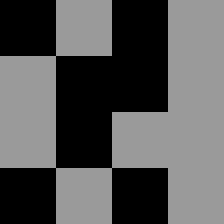

In [150]:
tensor_2_image(m)

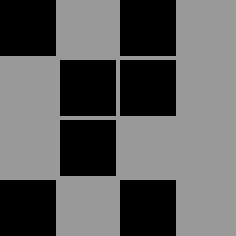

In [151]:
tensor_2_patch_image(m,patch_size=56)

## drop masking
x_mask, mask, ids_store -> x

In [168]:
x_ = torch.cat([x_masked, p_masked], dim=1)  # no cls token
# x_ = x_masked
x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x_masked.shape[2]))  # unshuffle
x_ = model.unpatchify(x_)
x_.shape

torch.Size([1, 3, 224, 224])

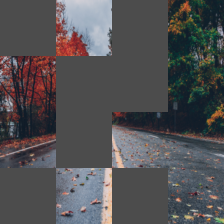

In [169]:
tensor_2_image(x_)

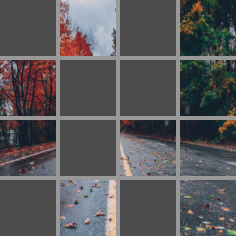

In [175]:
tensor_2_patch_image(x_, patch_size=56)

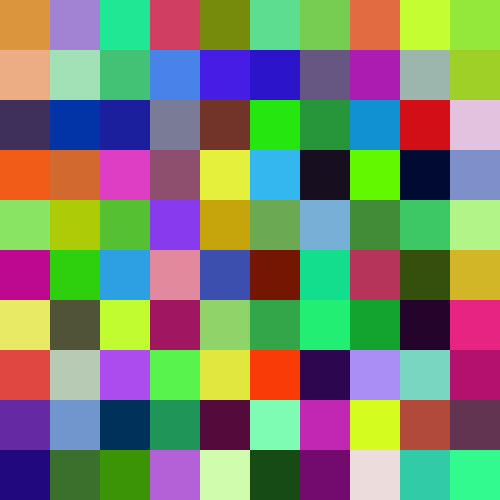

In [105]:
from PIL import Image, ImageDraw
import random

# 创建画布大小
grid_size = 10
cell_size = 50  # 每个网格的大小（像素）
width = grid_size * cell_size
height = grid_size * cell_size

# 创建新图片
image = Image.new("RGB", (width, height), "white")
draw = ImageDraw.Draw(image)

# 绘制网格
for row in range(grid_size):
    for col in range(grid_size):
        # 生成随机RGB颜色
        color = (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255)
        )
        
        # 计算当前网格的位置
        x0 = col * cell_size
        y0 = row * cell_size
        x1 = x0 + cell_size
        y1 = y0 + cell_size
        
        # 绘制矩形
        draw.rectangle([x0, y0, x1, y1], fill=color)

# 保存图片
# image.save("random_color_grid.png")
image.show()

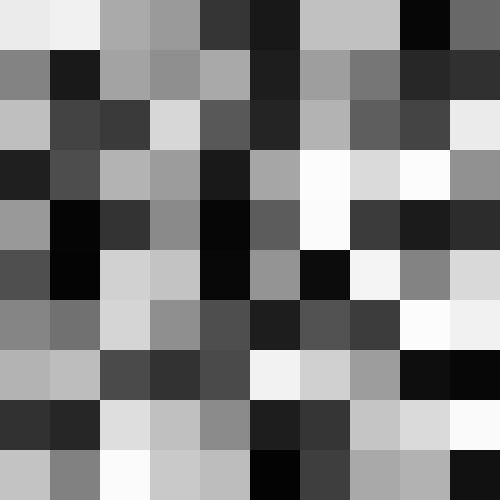

In [106]:
from PIL import Image, ImageDraw
import random

# 创建画布大小
grid_size = 10
cell_size = 50  # 每个网格的大小（像素）
width = grid_size * cell_size
height = grid_size * cell_size

# 创建新图片（模式为"L"表示灰度图像）
image = Image.new("L", (width, height), "white")
draw = ImageDraw.Draw(image)

# 绘制网格
for row in range(grid_size):
    for col in range(grid_size):
        # 生成随机灰度值
        gray_value = random.randint(0, 255)
        
        # 计算当前网格的位置
        x0 = col * cell_size
        y0 = row * cell_size
        x1 = x0 + cell_size
        y1 = y0 + cell_size
        
        # 绘制矩形
        draw.rectangle([x0, y0, x1, y1], fill=gray_value)

# 保存图片
# image.save("random_gray_grid.png")
image.show()

In [142]:
from PIL import Image, ImageDraw
import random

# 创建画布大小
grid_size = 10
cell_size = 50  # 每个网格的大小（像素）
width = grid_size * cell_size
height = grid_size * cell_size

# 创建随机颜色网格图片
def create_random_color_image():
    image = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(image)
    
    for row in range(grid_size):
        for col in range(grid_size):
            color = (
                random.randint(0, 255),
                random.randint(0, 255),
                random.randint(0, 255)
            )
            
            x0 = col * cell_size
            y0 = row * cell_size
            x1 = x0 + cell_size
            y1 = y0 + cell_size
            
            draw.rectangle([x0, y0, x1, y1], fill=color)
    
    return image

# 将一些彩色网格变成灰色块
def convert_to_gray(image, gray_probability=0.3):
    draw = ImageDraw.Draw(image)
    
    for row in range(grid_size):
        for col in range(grid_size):
            # 随机决定是否将该网格转换为灰度
            if random.random() < gray_probability:
                # 获取当前网格的颜色
                x0 = col * cell_size
                y0 = row * cell_size
                x1 = x0 + cell_size
                y1 = y0 + cell_size
                
                # 获取该区域的颜色并计算灰度值
                region = image.crop((x0, y0, x1, y1))
                # 计算平均颜色值作为灰度值
                average_color = sum(region.getcolors(maxcolors=256)[-1][-1]) // (cell_size * cell_size) 
                # print(average_color)
                # 绘制灰度值
                draw.rectangle([x0, y0, x1, y1], fill=(210,210,210))
    
    return image


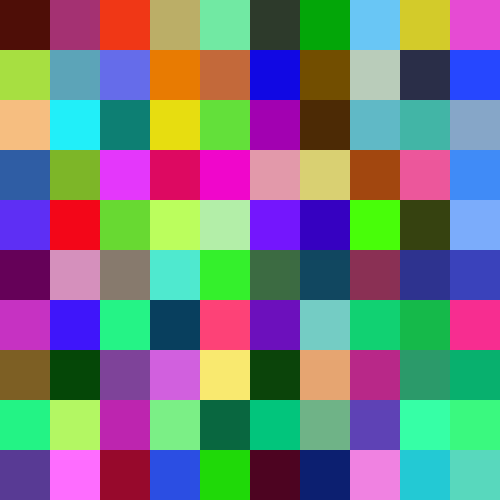

In [132]:
# 创建并保存图片
color_image = create_random_color_image()
color_image.show()

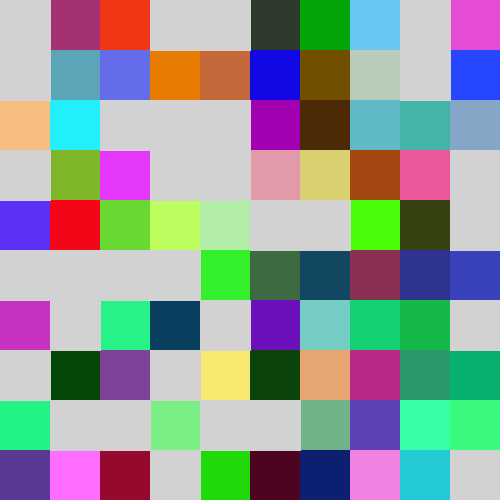

In [143]:
gray_image = color_image.copy()
gray_image = convert_to_gray(gray_image)

# gray_image.save("random_color_with_gray_grid.png")
gray_image.show()